# Setup

Classic notebook setup

In [1]:
# Automatically reloads modules before executing code.
# This ensures that any changes made to imported Python files (e.g. .py modules) 
# are reflected in the notebook without needing to restart the kernel.

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import matplotlib.pyplot as plt
from physics_simulator.pendulum import *

# Standard Pendulum Discovery

Let's discover the standard Pendulum behaviour

In [3]:
simple_pendulum = DampedPendulum()

In [4]:
start = time.perf_counter()
t, y = simple_pendulum.solve()
print(f"Solving pendulum motion took approx. {1000*(time.perf_counter() - start):.1f} milliseconds.")

Solving pendulum motion took approx. 5.1 milliseconds.


In [5]:
def plot_pendulum_angle(t, y, color=None, label=None):
    """
    Plots the angular position of a pendulum over time.

    Parameters
    ----------
    t : array-like
        Time values.
    y : array-like
        State vector (assumes y[0] is the angle).
    color : str or None, optional
        Line color for the plot.
    label : str or None, optional
        Label for the plot (used in the legend).
    """
    if y.shape[0] < 1:
        raise ValueError("Expected y to contain at least one row for angle data (y[0]).")

    plt.plot(t, y[0], color=color, label=label)
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (rad)")
    plt.grid(which="both", linestyle=":")

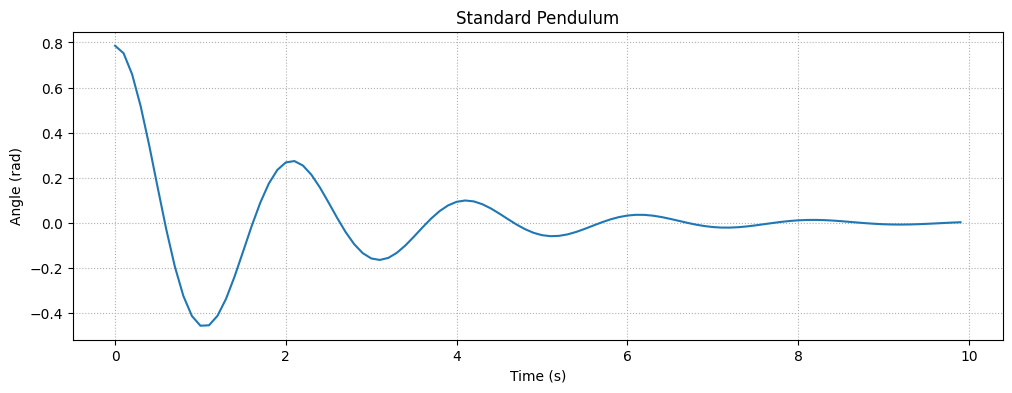

In [6]:
plt.figure(figsize=(12, 4))
plot_pendulum_angle(t, y)
plt.title("Standard Pendulum")
plt.show()

# Explore parameters sensitivity

I want to get an initial sense of which parameters influence the system and to what extent

#### Pendulum parameters

In [7]:
def pendulum_sensitivity_analysis_1D(param_grid):
    """
    Plots the sensitivity of the pendulum to 1D parameter variations.

    param_grid: dict, e.g. {"g": np.linspace(9, 10, 5)}
    """
    assert len(param_grid) == 1, "Only one parameter should vary at a time."

    param_name = next(iter(param_grid))
    param_values = param_grid[param_name]

    plt.figure(figsize=(12, 4))

    for val in param_values:
        params = {param_name: val}
        pendulum = DampedPendulum(**params)
        t, y = pendulum.solve()
        plot_pendulum_angle(t, y, label=f"{val:.3f}")

    label_titles = {
        "g": r"Gravity ($\mathrm{m/s^2}$)",
        "L": "Length (m)",
        "m": "Mass (kg)",
        "k": "Viscous damping coefficient (kg/s)"
    }

    plt.title(f"Sensitivity to {param_name}")
    plt.legend(title=label_titles.get(param_name, param_name), loc="upper right")
    plt.show()

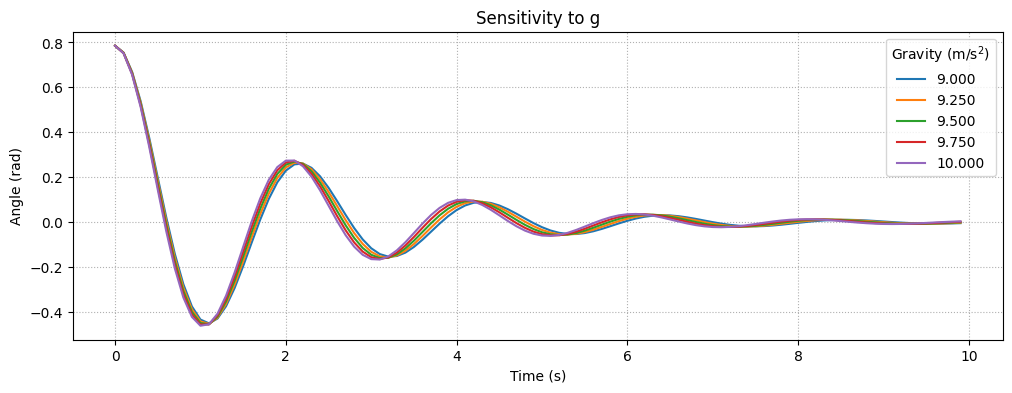

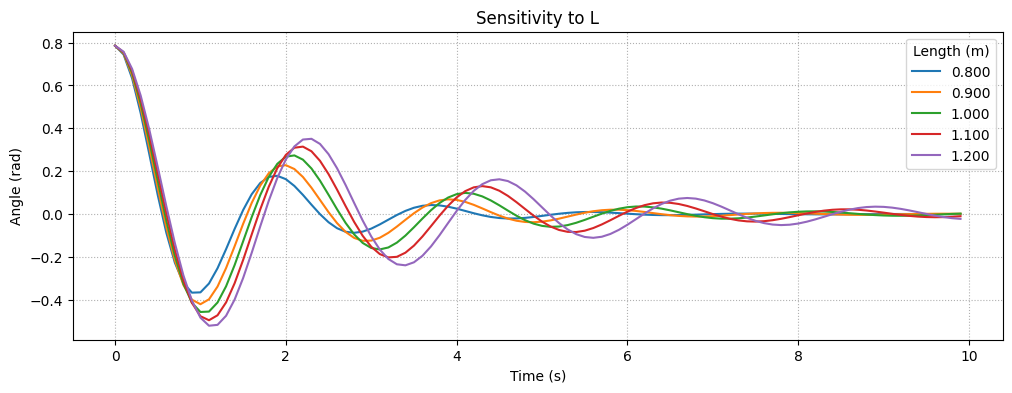

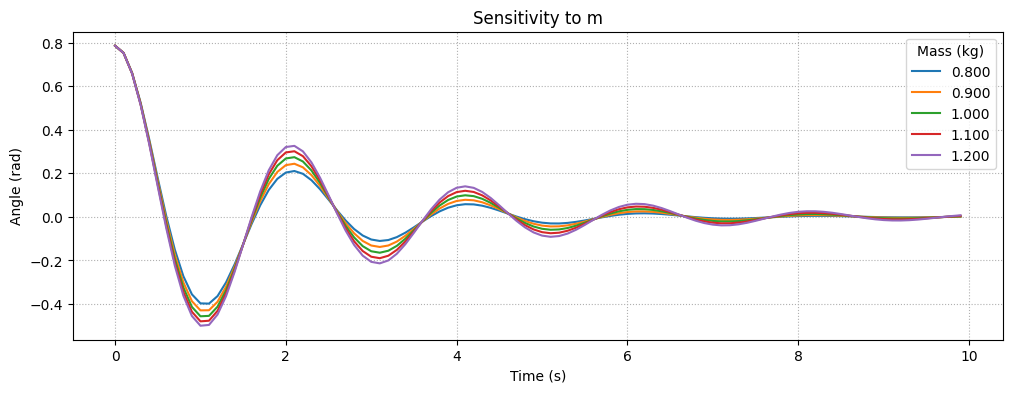

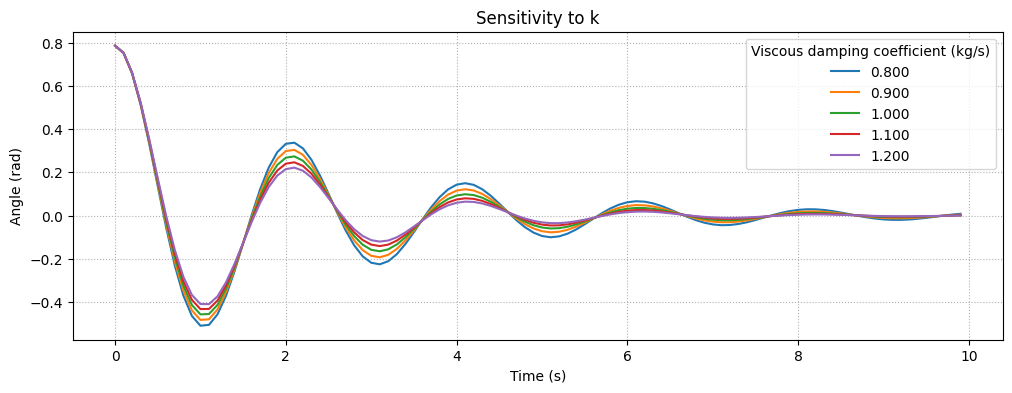

In [8]:
pendulum_sensitivity_analysis_1D({"g": np.linspace(9, 10, 5)})
pendulum_sensitivity_analysis_1D({"L": np.linspace(0.8, 1.2, 5)})
pendulum_sensitivity_analysis_1D({"m": np.linspace(0.8, 1.2, 5)})
pendulum_sensitivity_analysis_1D({"k": np.linspace(0.8, 1.2, 5)})

#### Solver parameters

In [9]:
def solver_sensitivity_analysis_1D(param_grid):
    """
    Plots the sensitivity of the solver to 1D parameter variations.

    param_grid: dict, e.g. {"theta0": np.linspace(-np.pi/2, np.pi/2, 5)}
    """
    assert len(param_grid) == 1, "Only one parameter should vary at a time."

    param_name = next(iter(param_grid))
    param_values = param_grid[param_name]

    plt.figure(figsize=(12, 4))

    for val in param_values:
        params = {param_name: val}
        pendulum = DampedPendulum()
        t, y = pendulum.solve(**params)
        plot_pendulum_angle(t, y, label=f"{val:.3f}")

    label_titles = {
        "theta0": "Initial angle (rad)",
        "omega0": "Initial angular speed (rad/s)",
        "dt": "Time step (s)"
    }

    plt.title(f"Sensitivity to {param_name}")
    plt.legend(title=label_titles.get(param_name, param_name), loc="upper right")
    plt.show()

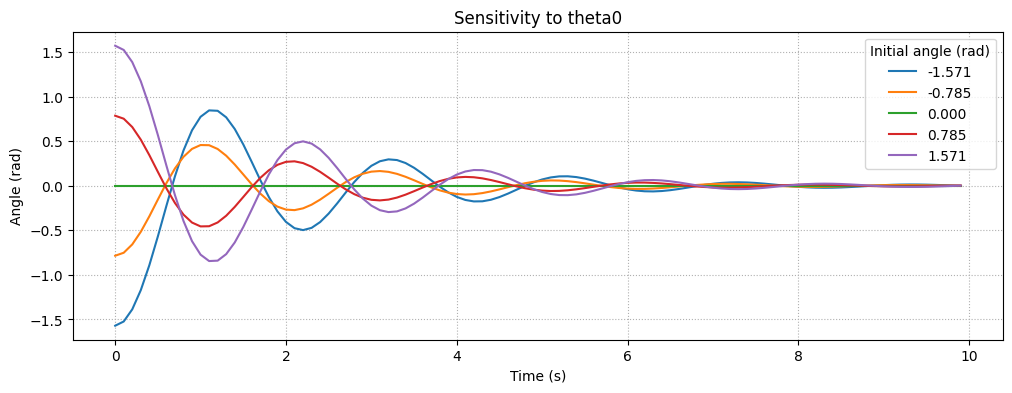

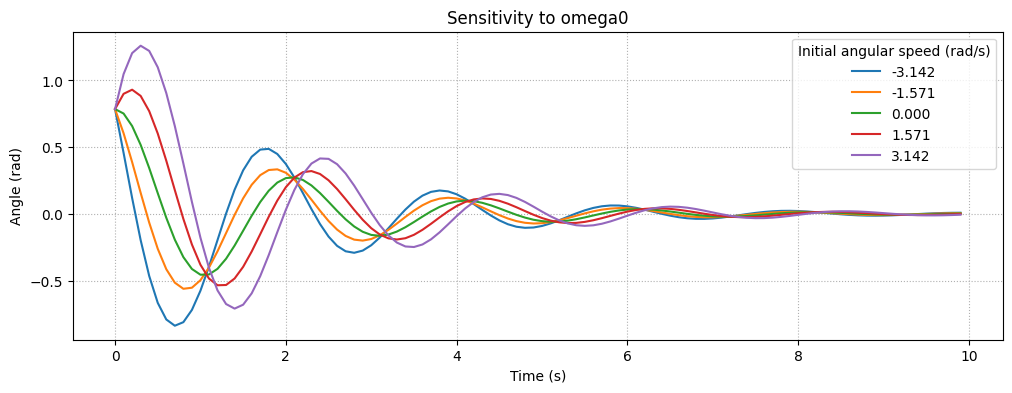

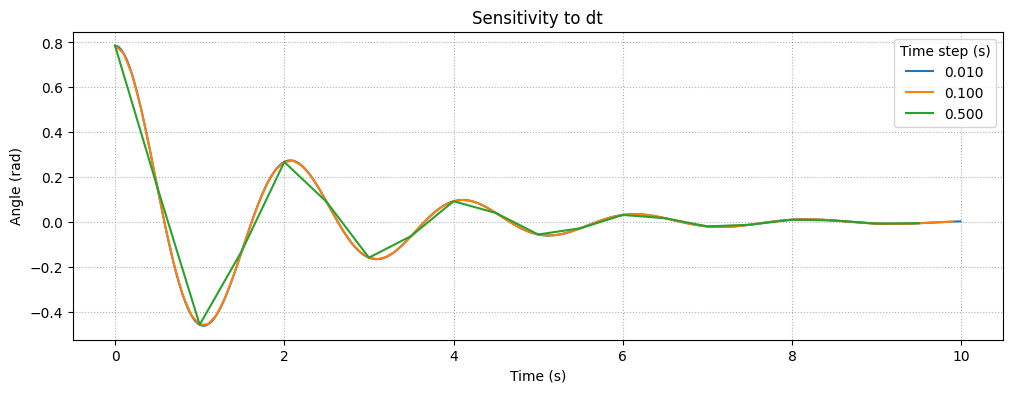

In [10]:
solver_sensitivity_analysis_1D({"theta0": np.linspace(-np.pi/2, np.pi/2, 5)})
solver_sensitivity_analysis_1D({"omega0": np.linspace(-np.pi, np.pi, 5)})
solver_sensitivity_analysis_1D({"dt": [0.01, 0.1, 0.5]})

# Convergence study with respect to the time step

A common approach in physics simulations is to perform a convergence study \
In our case, the point to point error is expected to be $\mathcal{O}(\mathrm{dt})$, while the $L^2$ error should scale as $\mathcal{O}(\mathrm{dt}^2)$

In [11]:
def convergence_study_dt(theta0=1.0, omega0=0.0, t_span=(0, 10), dt_values=None):
    """
    Plots convergence of the solver with respect to time step dt.

    Parameters
    ----------
    theta0 : float
        Initial angle.
    omega0 : float
        Initial angular speed.
    t_span : tuple
        Time interval for the simulation.
    dt_values : array-like
        List of time steps to test.
    """
    if dt_values is None:
        dt_values = np.logspace(-4, -1, 10)

    # Compute reference solution with very small dt
    pendulum = DampedPendulum()
    t_ref, y_ref = pendulum.solve(t_span=t_span, theta0=theta0, omega0=omega0, dt=1e-5)

    errors = []

    for dt in dt_values:
        t, y = pendulum.solve(t_span=t_span, theta0=theta0, omega0=omega0, dt=dt)

        # Interpolate solution onto ref grid (to compare)
        y_interp = np.interp(t_ref, t, y[0])  # Interpolate theta only

        error = np.linalg.norm(y_interp - y_ref[0]) / np.sqrt(len(t_ref))  # L2 norm
        errors.append(error)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.loglog(dt_values, errors, marker='o', label="Obtained Error")
    plt.loglog(dt_values, dt_values**2, ls="--", color="black", alpha=0.7, label=r"Expected Error")
    plt.xlabel("Time step (s)")
    plt.ylabel("L2 Error")
    plt.title("Convergence study of solver")
    plt.legend()
    plt.grid(which='both', ls=':')
    plt.show()


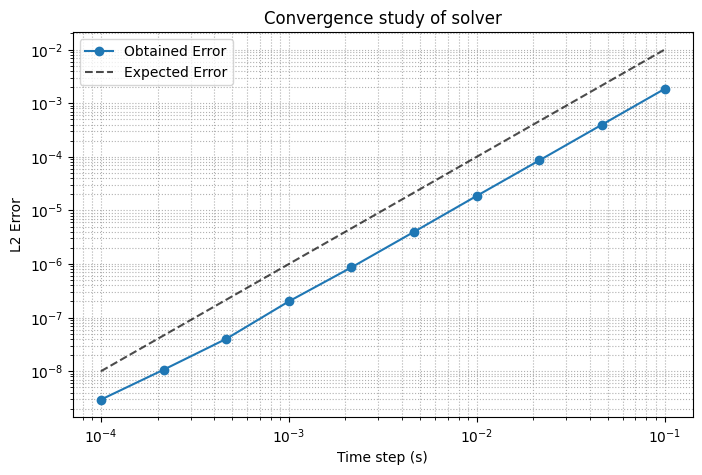

In [12]:
convergence_study_dt()